# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
# Import passengers.csv and set it as a time-series object. Plot the TS
df = pd.read_csv('passengers.csv')

In [2]:
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [3]:
df.Month = pd.to_datetime(df.Month)
df.set_index('Month', inplace=True)

In [4]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [5]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab
from statsmodels.tsa.stattools import adfuller
def stationarity_check(TS, column_name, rolling_window=7):

    # Calculate rolling statistics
    rolmean = TS.rolling(window = rolling_window, center = False).mean()
    rolstd = TS.rolling(window = rolling_window, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS[column_name])
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

Use your newly created function on the airpassenger data set.

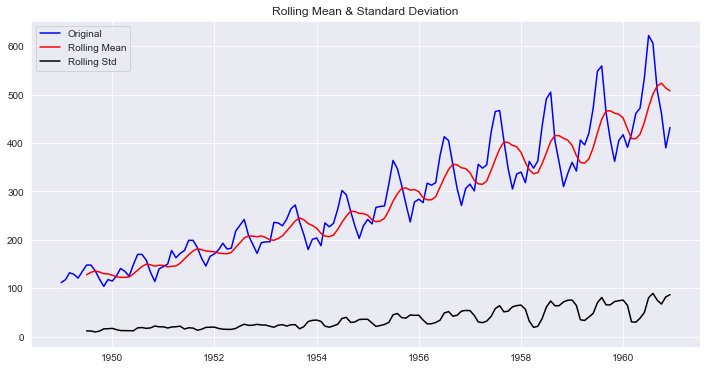

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [6]:
stationarity_check(df, '#Passengers')

## Perform a log() and sqrt() transform

In [7]:
# Log transform timeseries and compare with original to check the effect
log_df = np.log(df)

In [8]:
log_df.head()

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


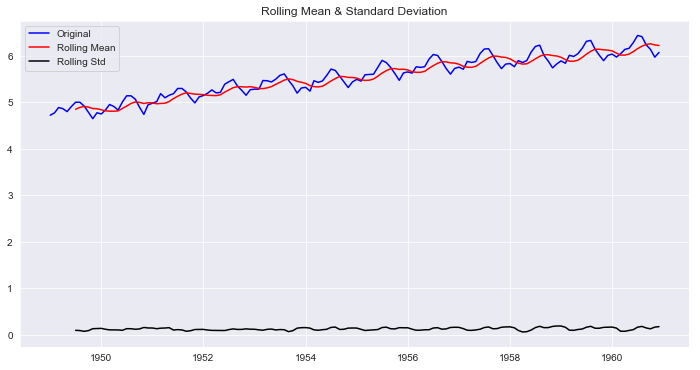

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [9]:
stationarity_check(log_df, '#Passengers')

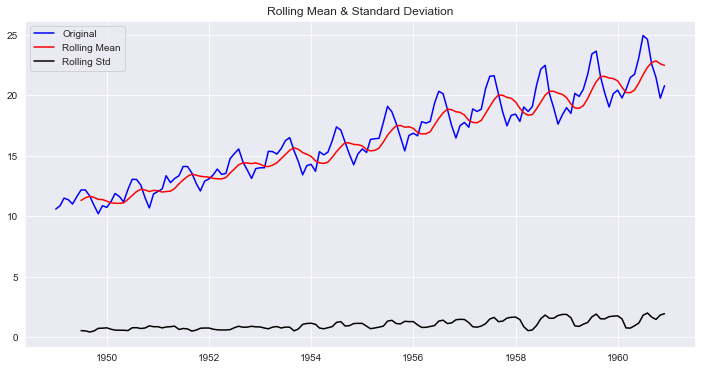

Results of Dickey-Fuller Test:
Test Statistic                  -0.345854
p-value                          0.918754
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
sqrt_df = np.sqrt(df)
stationarity_check(sqrt_df, '#Passengers')

moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

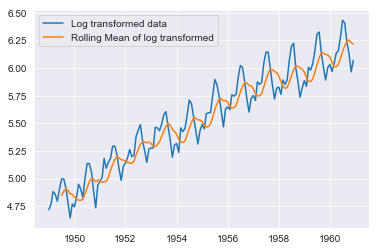

In [11]:
rolmean = log_df.rolling(window = 7, center = False).mean()
# rolstd = TS.rolling(window = 7, center = False).std()
plt.plot(log_df, label='Log transformed data')
plt.plot(rolmean, label='Rolling Mean of log transformed')
plt.legend();

Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [12]:
# Subtract the moving average from the original data and check head for Nans
log_df_sub_rolmean = log_df - rolmean
log_df_sub_rolmean.isna().sum()

#Passengers    6
dtype: int64

In [13]:
# Drop the NaN values from timeseries calculated above
log_df_sub_rolmean.dropna(inplace=True)

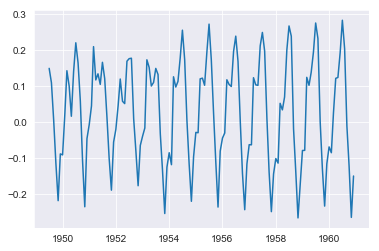

In [14]:
# Plot the result
plt.plot(log_df_sub_rolmean);

Finally, use your function `check_stationarity` to see if this series is considered stationary!

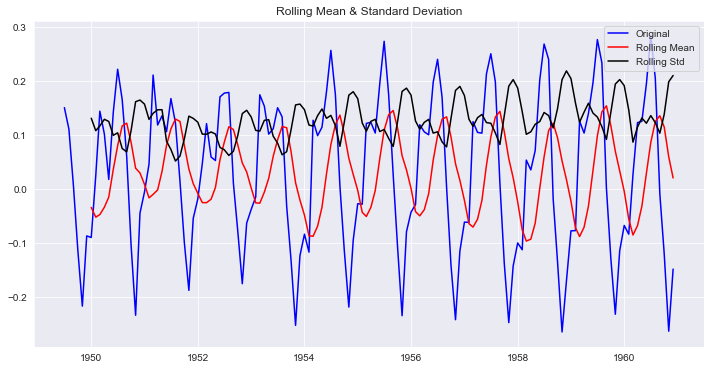

Results of Dickey-Fuller Test:
Test Statistic                  -2.348027
p-value                          0.156946
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


In [15]:
stationarity_check(log_df_sub_rolmean, '#Passengers')

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


In [16]:
print("Doing better! Still not stationary, but now only moving at a snail's pace.")

Doing better! Still not stationary, but now only moving at a snail's pace.


## Subtracting the weighted rolling mean

Repeat all the above for the *weighted* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

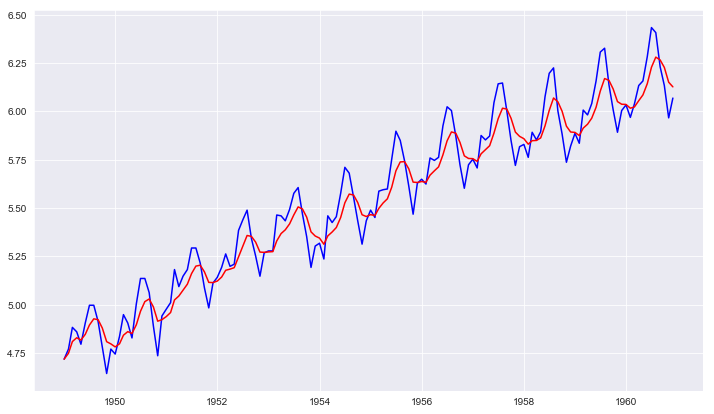

In [17]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
exp_rolmean = log_df.ewm(halflife = 2).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(log_df, color='blue',label='Original')
mean = plt.plot(exp_rolmean, color='red', label='Exponentially Weighted Rolling Mean')

In [18]:
# Subtract the moving average from the original data and plot
log_df_sub_wma = log_df - exp_rolmean

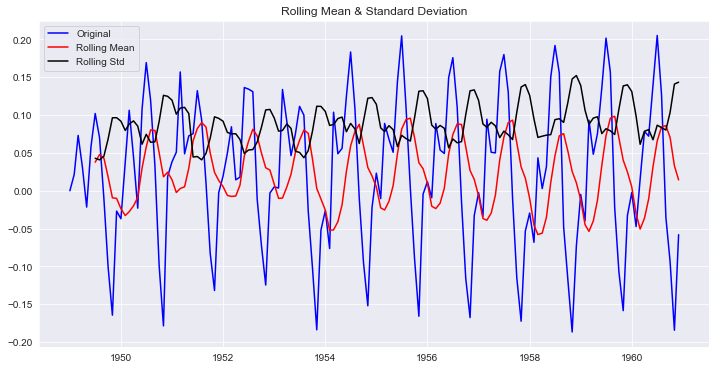

Results of Dickey-Fuller Test:
Test Statistic                  -3.087696
p-value                          0.027477
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [19]:
# do a stationarity check
stationarity_check(log_df_sub_wma, '#Passengers')

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


In [20]:
print("""
Because our p-value is below 0.05 and the Test Statistic is below 
the Critical Value for 5%, we can confidently say that our 
transformed time series data is now stationary.
""")


Because our p-value is below 0.05 and the Test Statistic is below 
the Critical Value for 5%, we can confidently say that our 
transformed time series data is now stationary.



## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [21]:
# difference your data and look at the head
log_diff = log_df_sub_wma.diff(periods=12)

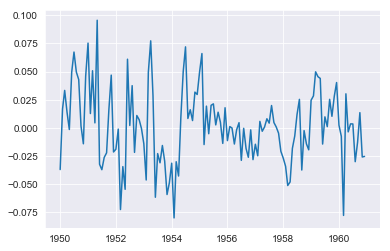

In [22]:
# plot your differenced time series
plt.plot(log_diff);

In [23]:
log_diff.isna().sum()

#Passengers    12
dtype: int64

In [24]:
# drop nas
log_diff.dropna(inplace=True)

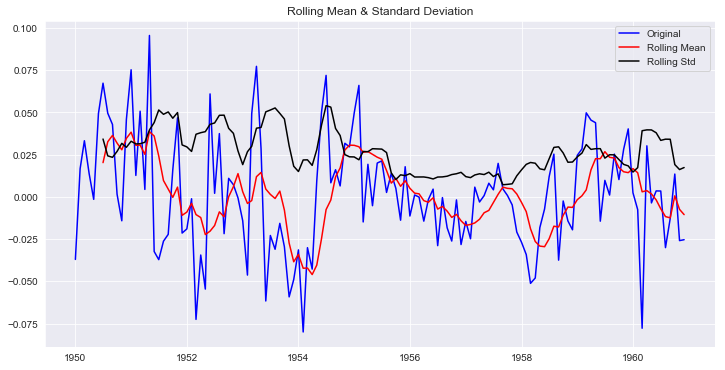

Results of Dickey-Fuller Test:
Test Statistic                  -4.158133
p-value                          0.000775
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [25]:
# perform the stationarity check
stationarity_check(log_diff, '#Passengers')

### Your conclusion

In [27]:
print("""
This is wonderful! Our p-value is amazing and the test statistic
is well below all the critical values. We have removed all trends
and seasonality, and are left with a seemingly random (white noise)
time series.
""")


This is wonderful! Our p-value is amazing and the test statistic
is well below all the critical values. We have removed all trends
and seasonality, and are left with a seemingly random (white noise)
time series.



## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.